In [25]:
import argparse
import os, sys
import time
import copy
import math
import pickle
import statistics

import numpy as np
import pandas as pd
import open3d as o3d
import torchvision
import pytorch3d
from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Import pytorch dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.modules.utils import _single, _pair, _triple

# Import toolkits
from summer2022_toolbox.visualization_3D_objects import *
from summer2022_toolbox.preprocessing import *
from summer2022_toolbox.read_object import *
from summer2022_toolbox.model_averaging import *
from summer2022_toolbox.model_PCA import *
from summer2022_toolbox.morphable_model import *
from summer2022_toolbox.model_evaluation import *

In [39]:
class T_net(nn.Module):
    """ Autoencoder for Point Cloud 
    Input: Batch of Point Cloud B x 3 x N
    Output: transformation matrix B x 3 x 3
    """
    def __init__(self, point_dim):
        super(T_net, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=point_dim, out_channels=64, kernel_size=1)
        self.conv4 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=1)
        self.conv5 = nn.Conv1d(in_channels=128, out_channels=1024, kernel_size=1)

        self.fc1 = nn.Linear(in_features=1024, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=point_dim*3)

        #batch norm
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)

        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)
    
    def forward(self, x):

        batch_size = x.shape[0]
        point_dim = x.shape[1]
        num_points = x.shape[2]

        #encoder
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv4(x)))
        x = F.relu(self.bn3(self.conv5(x)))

        # do max pooling 
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        #decoder
        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        reconstructed_points = self.fc3(x)

        #do reshaping
        transformation = reconstructed_points.reshape(batch_size, point_dim, point_dim)

        return transformation

In [41]:
# GPU check                
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device =='cuda':
    print("Run on GPU...")
else:
    print("Run on CPU...")

# Model Definition  
net = T_net(3)
net = net.to(device)

# Test forward pass
data = torch.randn(5,3,2048).to(device)
# Forward pass "data" through "net" to get output "out" 
out = net.forward(data)   #Your code here

# Check output shape
assert(out.detach().cpu().numpy().shape == (5,3,3))
print("Forward pass successful")

# Shape Observation
# Forward pass of a single image
data = torch.randn(5,3,2048).to(device)
# Forward pass "data" through "net" to get output "out" 
out = net.forward(data)   #Your code here

# Print the output shape and number of parameteres throughout the network
for name, module in net.named_modules():
    if isinstance(module, nn.Conv1d) or isinstance(module, nn.Linear):
        # # Get the weight of the module as a NumPy array
        weight = module.weight.cpu().detach().numpy()     #Your code here
        # # Compute the number of parameters in the weight
        num_Param = np.prod(weight.shape)  #Your code here
        
        print(f'{name:10} {str(weight.shape):20} {str(num_Param):10}')
#############################################

Run on GPU...
Forward pass successful
conv1      (64, 3, 1)           192       
conv4      (128, 64, 1)         8192      
conv5      (1024, 128, 1)       131072    
fc1        (512, 1024)          524288    
fc2        (256, 512)           131072    
fc3        (9, 256)             2304      


In [26]:
"""
model by dhiraj inspried from Charles
"""

import torch
import torch.nn as nn
import torch.nn.functional as F


class PCAutoEncoder(nn.Module):
    """ Autoencoder for Point Cloud 
    Input: Batch of Point Cloud B x 3 x N
    Output: reconstructed points
    """
    def __init__(self, point_dim, num_points):
        super(PCAutoEncoder, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=point_dim, out_channels=64, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=1)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=1)
        self.conv4 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=1)
        self.conv5 = nn.Conv1d(in_channels=128, out_channels=1024, kernel_size=1)

        self.fc1 = nn.Linear(in_features=1024, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=1024)
        self.fc3 = nn.Linear(in_features=1024, out_features=num_points*3)

        #batch norm
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
    
    def forward(self, x):

        batch_size = x.shape[0]
        point_dim = x.shape[1]
        num_points = x.shape[2]

        #encoder
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn1(self.conv2(x)))
        x = F.relu(self.bn1(self.conv3(x)))
        x = F.relu(self.bn2(self.conv4(x)))
        x = F.relu(self.bn3(self.conv5(x)))

        # do max pooling 
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)
        # get the global embedding
        global_feat = x

        #decoder
        x = F.relu(self.bn3(self.fc1(x)))
        x = F.relu(self.bn3(self.fc2(x)))
        reconstructed_points = self.fc3(x)

        #do reshaping
        reconstructed_points = reconstructed_points.reshape(batch_size, point_dim, num_points)

        return reconstructed_points , global_feat

### Sanity Check

In [27]:
# GPU check                
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device =='cuda':
    print("Run on GPU...")
else:
    print("Run on CPU...")

# Model Definition  
net = PCAutoEncoder(3, 2048)
net = net.to(device)

# Test forward pass
data = torch.randn(5,3,2048).to(device)
# Forward pass "data" through "net" to get output "out" 
out = net.forward(data)   #Your code here

# Check output shape
assert(out[0].detach().cpu().numpy().shape == (5,3,2048))
print("Forward pass successful")

# Shape Observation
# Forward pass of a single image
data = torch.randn(5,3,2048).to(device)
# Forward pass "data" through "net" to get output "out" 
out = net.forward(data)   #Your code here

# Print the output shape and number of parameteres throughout the network
for name, module in net.named_modules():
    if isinstance(module, nn.Conv1d) or isinstance(module, nn.Linear):
        # # Get the weight of the module as a NumPy array
        weight = module.weight.cpu().detach().numpy()     #Your code here
        # # Compute the number of parameters in the weight
        num_Param = np.prod(weight.shape)  #Your code here
        
        print(f'{name:10} {str(weight.shape):20} {str(num_Param):10}')
#############################################

Run on GPU...
Forward pass successful
conv1      (64, 3, 1)           192       
conv2      (64, 64, 1)          4096      
conv3      (64, 64, 1)          4096      
conv4      (128, 64, 1)         8192      
conv5      (1024, 128, 1)       131072    
fc1        (1024, 1024)         1048576   
fc2        (1024, 1024)         1048576   
fc3        (6144, 1024)         6291456   


### Import Preprocessed ModelNet40 cars

In [28]:
#load all aligned cars
f1 = open('train.txt','rb')
X_train = pickle.load(f1)
f2 = open('test.txt','rb')
X_test = pickle.load(f2)

In [29]:
TRAIN_BATCH_SIZE = 12
VAL_BATCH_SIZE = 10

# construct dataloader
train_loader = DataLoader(
    X_train, 
    batch_size=TRAIN_BATCH_SIZE, 
    shuffle=True, 
    num_workers=4
)
val_loader = DataLoader(
    X_test, 
    batch_size=VAL_BATCH_SIZE, 
    shuffle=False, 
    num_workers=4
)

### Deploy model on GPU

In [30]:
# GPU check                
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device =='cuda':
    print("Run on GPU...")
else:
    print("Run on CPU...")

# Model Definition  
model = PCAutoEncoder(3, X_train[0].shape[1])
model = model.to(device)

# Check if on GPU
assert(next(model.parameters()).is_cuda)

Run on GPU...


In [31]:
from pytorch3d.loss import chamfer_distance
# initial learning rate = 0.1, decay rate = 0.1
INITIAL_LR = 0.001

# momentum for optimizer = 0.9
MOMENTUM = 0.9

# L2 regularization strength = 0.0001
REG = 1e-4

# create loss function: Chamfer distance
criterion = lambda recon_x, x: chamfer_distance(recon_x, x)

# Add optimizer
optimizer = optim.Adam(model.parameters(), lr=INITIAL_LR)

### Training

In [32]:
# some hyperparameters
# total number of training epochs
EPOCHS = 50
DECAY_EPOCHS = 20
DECAY = 0.7
# DECAY = 0.1

# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

# start the training/validation process
# the process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
best_loss = 1e20
current_learning_rate = INITIAL_LR

start = time.time()
print("==> Training starts!")
print("="*50)

# store loss learning curve
train_loss_lst = []
valid_loss_lst = []

for i in range(0, EPOCHS):
    # handle the learning rate scheduler.
    if i % DECAY_EPOCHS == 0 and i != 0:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" %current_learning_rate)
    
    
    # switch to train mode
    model.train()
    
    print("Epoch %d:" %i)

    train_loss = 0 # track training loss if you want
    
    # Train the model for 1 epoch.
    for batch_idx, (inputs) in enumerate(train_loader):
        # copy inputs to device
        inputs = inputs.float().to(device)

        # compute the output and loss
        outputs, _ = model(inputs)

        inputs = inputs.transpose(1, 2)
        outputs = outputs.transpose(1, 2)
        dist1, _ = criterion(outputs, inputs)

        loss = (torch.mean(dist1))
        train_loss += loss.to('cpu').detach().numpy()

        # zero the gradient
        optimizer.zero_grad()

        # backpropagation
        loss.backward()

        # apply gradient and update the weights
        optimizer.step()

    avg_loss = train_loss / len(train_loader)
    print("Training loss: %.4f" %(avg_loss))
    train_loss_lst.append(avg_loss)

    # switch to eval mode
    model.eval()

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0
    
    val_loss = 0 # again, track the validation loss if you want
    
    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs) in enumerate(val_loader):
            # copy inputs to device
            inputs = inputs.float().to(device)
            # compute the output and loss
            outputs, _ = model(inputs)

            inputs = inputs.transpose(1, 2)
            outputs = outputs.transpose(1, 2)

            dist1, _ = criterion(outputs, inputs)

            loss = (torch.mean(dist1))
            val_loss += loss

    avg_loss = val_loss / len(val_loader)
    print("Validation loss: %.4f" % (avg_loss))
    
    valid_loss_lst.append(avg_loss.cpu().detach().numpy())
    
    # save the model checkpoint
    if avg_loss < best_loss:
        best_val_acc = avg_loss
        if not os.path.exists(CHECKPOINT_FOLDER):
            os.makedirs(CHECKPOINT_FOLDER)
        print("Saving ...")
        state = {'state_dict': model.state_dict(),
                'epoch': i,
                'lr': current_learning_rate}
        torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'resnet20.pth'))
        
    print('')

print("="*50)
print(f"==> Optimization finished in {time.time() - start:.2f}s! Best validation accuracy: {best_val_acc:.4f}")

==> Training starts!
Epoch 0:
Training loss: 105137.9729
Validation loss: 104256.6172
Saving ...

Epoch 1:
Training loss: 97862.3217
Validation loss: 102326.9297
Saving ...

Epoch 2:
Training loss: 90273.5354
Validation loss: 98593.7969
Saving ...

Epoch 3:
Training loss: 82937.6098
Validation loss: 86987.1562
Saving ...

Epoch 4:
Training loss: 75560.9986
Validation loss: 88900.7266
Saving ...

Epoch 5:
Training loss: 68561.7410
Validation loss: 88756.0312
Saving ...

Epoch 6:
Training loss: 60879.2847
Validation loss: 77508.5625
Saving ...

Epoch 7:
Training loss: 55961.0434
Validation loss: 70747.4922
Saving ...

Epoch 8:
Training loss: 49247.3070
Validation loss: 71952.2734
Saving ...

Epoch 9:
Training loss: 43395.5290
Validation loss: 79482.8359
Saving ...

Epoch 10:
Training loss: 37826.7328
Validation loss: 74181.9688
Saving ...

Epoch 11:
Training loss: 33334.5831
Validation loss: 65264.1680
Saving ...

Epoch 12:
Training loss: 28255.8593
Validation loss: 66762.8906
Saving ...

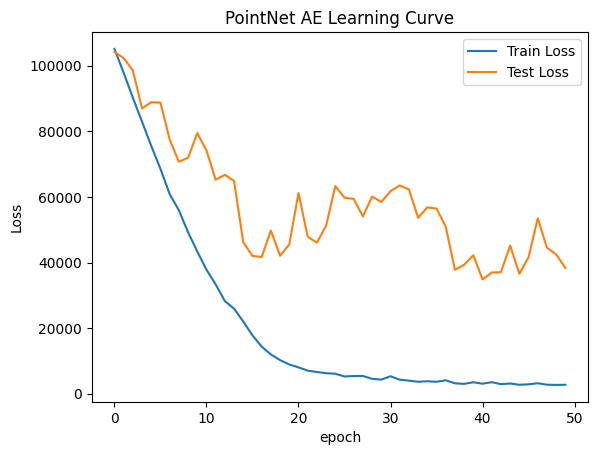

In [34]:
plt.plot(train_loss_lst, label='Train Loss')
plt.plot(valid_loss_lst, label='Test Loss')
plt.title("PointNet AE Learning Curve")
plt.legend()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.show()

In [42]:
x = train_loader.__iter__().next() # hack to grab a batch

inputs = x.float().to(device)

outputs, _ = model(inputs)

X = inputs.cpu().detach().numpy()[0]
X_hat = outputs.cpu().detach().numpy()[0]

draw3DPoints(X)
draw3DPoints(X_hat)
